In [1]:
import sys 
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Clearvale/jake_scripts/Amy_flywheel_scripts/')

import numpy as np
import pandas as pd
import os
import glob
import scipy.io 

# Base path to your .mat files
base_path = '/pl/active/banich/studies/wmem/fmri/subjects/rest_results/*/rest_processing_batch/results/firstlevel/SBC_01/resultsROI_Subject*_Condition001.mat'

# Get list of all subject directories
subject_dirs = sorted(glob.glob('/pl/active/banich/studies/wmem/fmri/subjects/rest_results/*'))

mat_files = []

for subject_dir in subject_dirs:
    subject_number = os.path.basename(subject_dir)
    subject_path = f'/pl/active/banich/studies/wmem/fmri/subjects/rest_results/{subject_number}/rest_processing_batch/results/firstlevel/SBC_01/resultsROI_Subject*_Condition001.mat'
    if glob.glob(subject_path):
        mat_files.extend(glob.glob(subject_path))

In [2]:
# Dictionary to store Z matrices by subject number
subject_z_matrices = {}

# Process each .mat file
for mat_file in mat_files:
    # Load the .mat file
    mat_contents = scipy.io.loadmat(mat_file)

    # Access the variable 'Z'
    if 'Z' in mat_contents:
        Z = mat_contents['Z']
        np.fill_diagonal(Z, 1)
        subject_number = subject_number = mat_file.split('/')[9] 
        subject_z_matrices[subject_number] = Z
        print(f'Processed Subject {subject_number}')
    else:
        print(f"Variable 'Z' not found in {mat_file}.")

# Convert to a list if needed
subject_z_list = sorted([(subject, z_matrix) for subject, z_matrix in subject_z_matrices.items()])

Processed Subject 001
Processed Subject 002
Processed Subject 004
Processed Subject 005
Processed Subject 006
Processed Subject 008
Processed Subject 009
Processed Subject 010
Processed Subject 011
Processed Subject 012
Processed Subject 013
Processed Subject 015
Processed Subject 017
Processed Subject 018
Processed Subject 020
Processed Subject 021
Processed Subject 022
Processed Subject 023
Processed Subject 027
Processed Subject 029
Processed Subject 031
Processed Subject 032
Processed Subject 033
Processed Subject 034
Processed Subject 035
Processed Subject 036
Processed Subject 040
Processed Subject 042
Processed Subject 044
Processed Subject 045
Processed Subject 046
Processed Subject 047
Processed Subject 050
Processed Subject 052
Processed Subject 053
Processed Subject 054
Processed Subject 055
Processed Subject 057
Processed Subject 059
Processed Subject 061
Processed Subject 062
Processed Subject 063
Processed Subject 064
Processed Subject 065
Processed Subject 067
Processed 

In [15]:
import numpy as np

# Assuming subject_z_list is already defined and contains the Z matrices
subject_mats = [subject_z_list[i][1] for i in range(len(subject_z_list))]

# Stack the matrices along a new axis
stacked_mats = np.stack(subject_mats, axis=-1)

# Compute the average across the new axis
average_matrix = pd.DataFrame(np.mean(stacked_mats, axis=-1))


<AxesSubplot:>

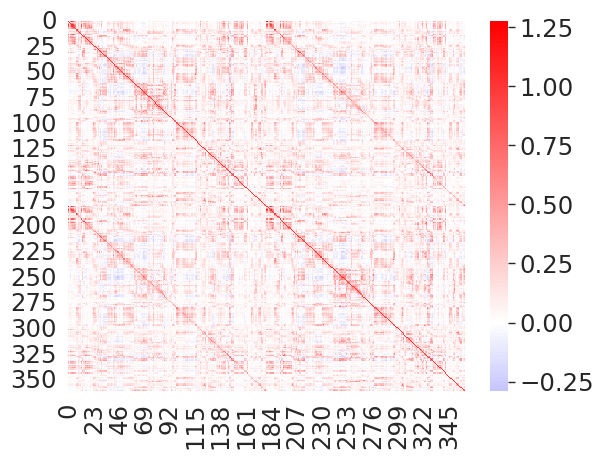

In [33]:
import seaborn as sns 

sns.heatmap(average_matrix, center=0, cmap='bwr')

In [17]:
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/analysis/')
from clearmem_my_functions import *

import sys
sys.path.append('/home/jade6100/.local/lib/python3.7/site-packages')
import scikit_posthocs as sp
import itertools

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats
from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

#import statsmodels.api as sm
#from statsmodels.formula.api import ols
#from scipy import stats
#import scikit_posthocs as sp

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold

def getF(data, var, group):
    data[var] = data[var].astype('float')
    model = ols(var + '~ C('+group+')', data=data).fit()
    anova_table = np.array(sm.stats.anova_lm(model, type=2)[['F', 'PR(>F)']])[0]
    return anova_table.round(4)

def getposthoc(data, var, group):
    data[var] = data[var].astype('float')
    model = ols(var + '~ C('+group+')', data=data).fit()
    post_hoc = sp.posthoc_ttest(data, val_col=var, group_col=group,
                                p_adjust='fdr_bh').sort_index().sort_index(axis = 1)
    post_hoc.columns = list(range(1, len(uni(data[group]))+1))
    return post_hoc

def vsim(data, parcel=None):
    
    if parcel is None:
        parcel_row = pd.DataFrame(np.flip(np.array(data.T))).T
        
    else:
        parcel_row = pd.DataFrame(np.flip(np.array(data.iloc[[parcel]].T))).T
    a = np.array(parcel_row.T.iloc[:, 0: 1]).squeeze()
    n = int(np.sqrt(len(a)*2))+1
    mask = np.tri(n,dtype=bool, k=-1) # or np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n))
    out[mask] = a
    out = out + out.T - np.diag(np.diag(out))
    out[np.diag_indices_from(out)]
    sim_mat = pd.DataFrame(np.flip(out))
  

    return(sim_mat)
    
def grad_centroid_vsim(data, grad): 
    new_row_cluster = data[data['grad'] == grad]
    new_row_cluster = new_row_cluster.drop(['grad'], axis=1)
    clust_centroid = pd.DataFrame(new_row_cluster.mean(), columns = ['Mean']).T
    
    sim_mat = vsim(clust_centroid)
    
    return(sim_mat)


def threshold_proportional(W,p,copy=True):

    if p>1 or p<0:
        raise BCTParamError('Threshold must be in range [0,1]')
    if copy: W=W.copy()
    n=len(W)						# number of nodes
    np.fill_diagonal(W, 0)			# clear diagonal

    if np.all(W==W.T):				# if symmetric matrix
        W[np.tril_indices(n)]=0		# ensure symmetry is preserved
        ud=2						# halve number of removed links
    else:
        ud=1

    ind=np.where(W)					# find all links

    I=np.argsort(W[ind])[::-1]		# sort indices by magnitude

    en=int(round((n*n-n)*p/ud))		# number of links to be preserved

    W[(ind[0][I][en:],ind[1][I][en:])]=0	# apply threshold
    #W[np.ix_(ind[0][I][en:], ind[1][I][en:])]=0

    if ud==2:						# if symmetric matrix
        W[:,:]=W+W.T						# reconstruct symmetry

    return W


import plotly.graph_objs as go
from plotly.subplots import make_subplots
import itertools

def plot_3Dfigure(newX, colors, title='', net=None, filepath=None):
    fig = plt.figure()
    
    if net is not None:
        data = go.Scatter3d(x=newX[:,0], y=newX[:,1], z=newX[:,2], 
                            mode='markers',
                            marker=dict(size=5,
                                        #color=newX[:,1],
                                        color=colors,
                                        opacity=0.7,
                                        colorscale=colors)
                           )
    else:
        data = go.Scatter3d(x=newX[:,0], y=newX[:,1], z=newX[:,2], 
                            mode='markers',
                            marker=dict(size=5,
                                        color=newX[:,1],
                                        opacity=0.7,
                                        colorscale='jet')
                           )
    
    layout = go.Layout(title_text=title,title_x=0.5,title_y=0.8,title_font_size=12)
    fig = go.Figure(data=[data], layout=layout)
    fig.update_layout(showlegend=False)
    fig.update_xaxes(showticklabels=False)
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(scene = dict(
                    xaxis = dict(title= '', ticks= '', showticklabels= False,),
                    yaxis = dict(title= '', ticks= '', showticklabels= False,),
                    zaxis = dict(title= '', ticks= '', showticklabels= False,),
                    ))
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    #fig.show()
    
    if filepath is not None:
        fig.write_html(filepath+'3d_grads.html')
        

from pylab import *

def get_color_maps(cmap, n, nrep):
    from PIL import Image, ImageColor

    cmap = cm.get_cmap(cmap, n)    # PiYG
    converted_list = []
    for i in range(cmap.N):
        rgba = cmap(i)
        # rgb2hex accepts rgb or rgba
        hexc = matplotlib.colors.rgb2hex(rgba)
        codes = ImageColor.getcolor(str(hexc), "RGB")

        c1 = list(itertools.repeat(int(codes[0])/255, nrep))
        c2 = list(itertools.repeat(int(codes[1])/255, nrep))
        c3 = list(itertools.repeat(int(codes[2])/255, nrep))
        
        converted = pd.concat([pd.DataFrame(c1), pd.DataFrame(c2), pd.DataFrame(c3)], axis = 1)
        converted.columns = ['r', 'g', 'b']
        converted_list.append(converted)
        
    final = pd.concat(converted_list).reset_index(drop=True)
    final['index_new'] = list(range(0,final.shape[0]))
    
    return final

def show_grads(data):
    import nibabel as nib
    import nilearn.plotting as plotting
    import numpy as np
    import matplotlib.pyplot as plt
    get_ipython().run_line_magic('matplotlib', 'inline')
    import pandas as pd
    import hcp_utils as hcp

    def listToDict(lstA, lstB):
        zipped = zip(lstA, lstB)
        op = dict(zipped)
        return op

    def uni(list1):
        unique_list = []
        # traverse for all elements
        for x in list1:
            # check if exists in unique_list or not
            if x not in unique_list:
                unique_list.append(x)

        return(unique_list)

    glasser = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/analysis/glasser_regions/spearman_subtype_glasser_regions.csv').drop('regionID', axis =1).rename({'Unnamed: 0':'regionID'}, axis = 1)
    glasser['regionID'] = glasser['regionID'] + 1
    
    mesh_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/hcp-utils/hcp_utils/data/'
    mesh_sub = hcp.load_surfaces(example_filename=mesh_path+'S1200.R.pial_MSMAll.32k_fs_LR.surf.gii')
    
    regs = data 
    regs['regionID'] = regs['index'] + 1
    regs = pd.merge(regs, glasser, on = 'regionID')
    regs = regs[['regionID', 'Subtype_x', 'grad', 'regionName', 'regionLongName', 'Lobe', 'cortex', 'r', 'g', 'b']]
  
    maps_df = pd.DataFrame(hcp.mmp.rgba).T
    maps_df = maps_df.reset_index().rename({'index':'regionID'}, axis = 1)
    maps_df['regionID'] = maps_df['regionID'] +1
    maps_df = pd.DataFrame(hcp.mmp.rgba).T
    maps_df = maps_df.reset_index().rename({'index':'regionID'}, axis = 1)
    maps_df['regionID'] = maps_df['regionID'] +1

    new_maps_df = pd.merge(regs, maps_df, on = "regionID").sort_values('regionID')
    new_maps_df[0] = new_maps_df['r']
    new_maps_df[1] = new_maps_df['g']
    new_maps_df[2] = new_maps_df['b']
    new_maps_df = new_maps_df[[0, 1,2,3]]

    first = pd.DataFrame(np.array([0, 0, 0, 0])).T
    more = pd.concat([pd.DataFrame(np.zeros(20)), pd.DataFrame(np.zeros(20)), pd.DataFrame(np.zeros(20)), pd.DataFrame(np.zeros(20))], axis= 1)
    more.columns = [0,1,2,3]

    new_maps_df = pd.concat([first, new_maps_df, more])

    map_l = []
    out_l = []
    for i in range(0, len(new_maps_df)):
        map_l.append(i)
        out_l.append(np.array(new_maps_df.iloc[i:i+1])[0])

    hcp.mmp.rgba = listToDict(map_l, out_l)

    return hcp.view_parcellation(mesh_sub.inflated, hcp.mmp)

def get_colors(cmap, n):
        from PIL import Image, ImageColor

        cmap = cm.get_cmap(cmap, n)    # PiYG
        converted_list = []
        for i in range(cmap.N):
            rgba = cmap(i)
            # rgb2hex accepts rgb or rgba
            hexc = matplotlib.colors.rgb2hex(rgba)
            converted_list.append(hexc)

        return converted_list
    
    
def show_code(function):  
    import inspect
    lines = inspect.getsource(function)
    print(lines)
    
jets = get_colors('jet_r', 20)


net_cols = ['#FCFF0D', '#21DFB4', '#4E00A2', '#F00087']
ops_cols = ['#F0180A', '#F08B0A', '#6DAE45', '#0A5AF0']


def reduce_memory_usage(df, verbose=False):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [8]:
def create_func_mat(data):
    
    from sklearn.preprocessing import MinMaxScaler
    
    X = np.array(data)
    
    #X_Z = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, dtype=np.float64, ddof=1, keepdims=True)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    D = X
    perc = np.array([np.percentile(x, 90) for x in D])

    for i in range(D.shape[0]):
        D[i, D[i,:] < perc[i]] = 0    
    
    D[D < 0] = 0
    D = 1 - pairwise_distances(D, metric = 'cosine')
    #scaler = MinMaxScaler(feature_range=(.5,1))
    #D = scaler.fit_transform(D)
    
    D = pd.DataFrame(D)
    # D = aff
    
    return(D)

In [27]:
group_func_mat = create_func_mat(average_matrix)
group_func_mat.columns = range(1,361)
group_func_mat.index = range(1,361)

<AxesSubplot:>

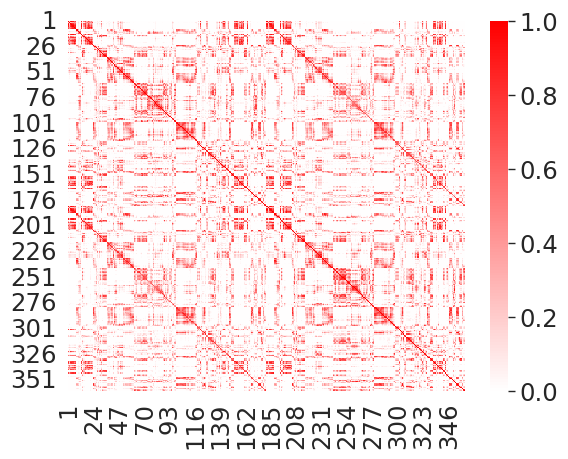

In [28]:
sns.heatmap(group_func_mat, center=0, cmap='bwr')

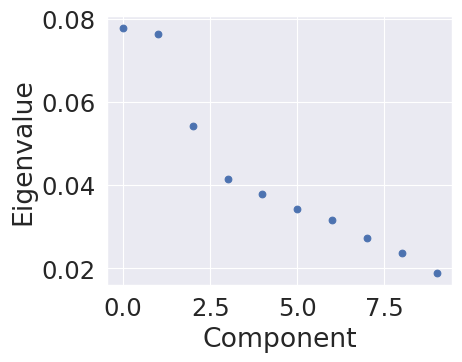

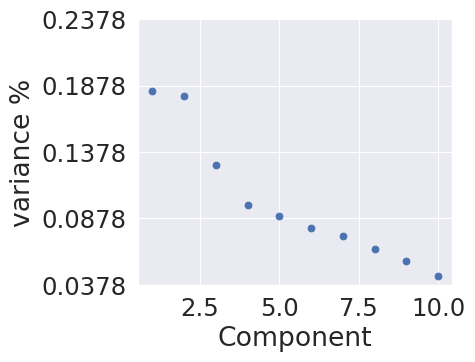

In [29]:
def group_grads(func_mat):
    from brainspace.gradient import GradientMaps
    from brainspace.plotting import plot_hemispheres
    from brainspace.utils.parcellation import map_to_labels
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    from brainspace.null_models import SurrogateMaps
    import seaborn as sns

    gj = GradientMaps(approach='dm', random_state=0, 
                      kernel='normalized_angle',
                      #n_components=3
                     )
    gj_out = gj.fit(np.array(group_func_mat))

  

    #for i in range(1):
    sns.set_context("paper", font_scale = 2)

    fig, ax = plt.subplots(1, figsize=(5, 4))
    ax.scatter(range(gj_out.lambdas_.size), gj_out.lambdas_)
    ax.set_xlabel('Component')
    ax.set_ylabel('Eigenvalue')
    fig.tight_layout()
    #fig.savefig('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/grp/eigen_components.png')

    fig, ax = plt.subplots(1, figsize=(5, 4))
    variance = gj_out.lambdas_
    ax.scatter(range(1,11), variance/variance.sum())
    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end+.05, 0.05))
    ax.set_xlabel('Component')
    ax.set_ylabel('variance %')
    variance/variance.sum()
    fig.tight_layout()
    #fig.savefig('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/grp/variance_explained.png')

    
    newX = pd.DataFrame(gj_out.gradients_[:, :3], columns=['g1', 'g2', 'g3'])

    return newX

group_grad_df = group_grads(group_func_mat)
#group_grad_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/grp/rest_group_grads.csv', index=False)

In [30]:
wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
wm_networks = wm_networks.reset_index()
wm_networks[['parcel_id']] = wm_networks[['index']] + 1
wm_networks = wm_networks[['parcel_id', 'Subtype']]
net_cols = ['#FCFF0D', '#21DFB4', '#4E00A2', '#F00087']

colors = wm_networks.Subtype.map({1:net_cols[0], 2:net_cols[1], 3:net_cols[2], 4:net_cols[3]})
colors_parcels = colors.reset_index()
colors_parcels[['parcel_id']] = colors_parcels[['index']] + 1
colors_parcels = colors_parcels[['parcel_id', 'Subtype']]

In [31]:
colors_parcels = colors.reset_index()
colors_parcels[['parcel_id']] = colors_parcels[['index']] + 1
colors_parcels = colors_parcels[['parcel_id', 'Subtype']]

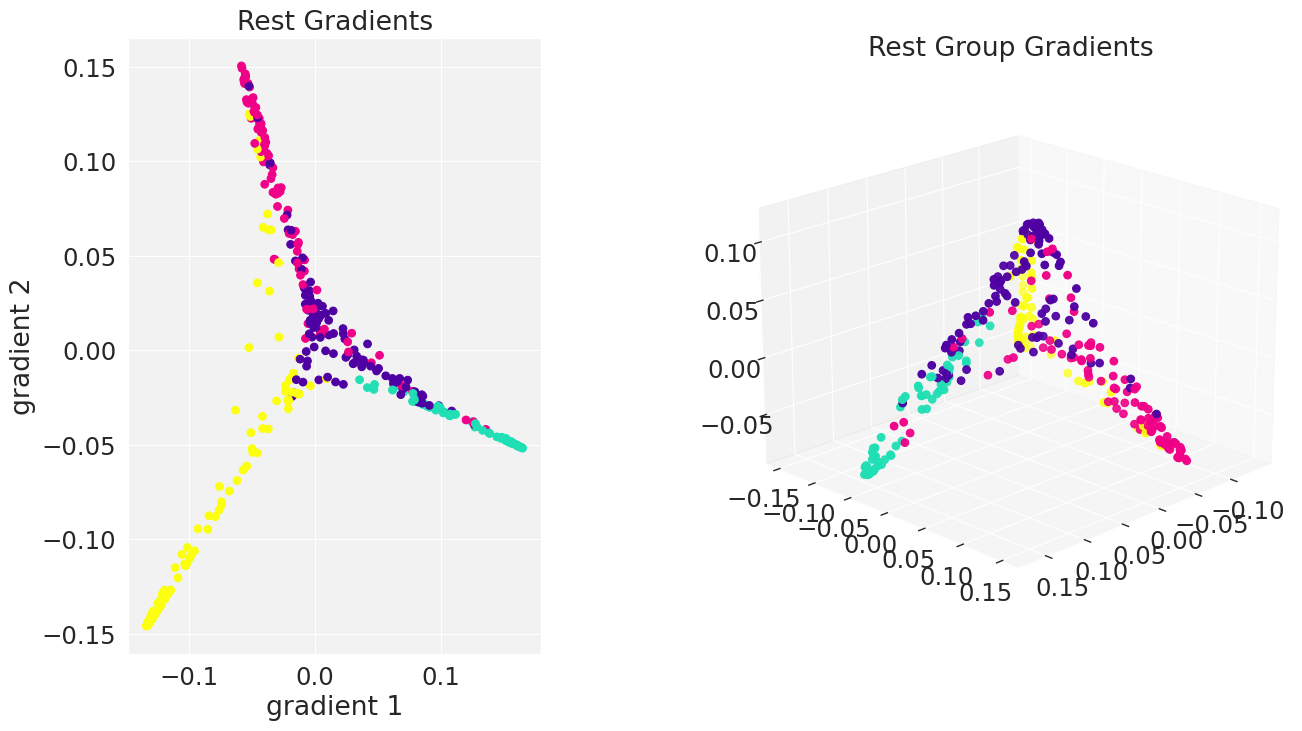

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Setting up the figure for side-by-side plots with white background
fig = plt.figure(figsize=(16, 8), facecolor='white')  # Reducing overall width and setting figure background to white

# Adjusting the 2D Scatter plot on the left
ax1 = fig.add_subplot(121, aspect=1.5, facecolor='#F2F2F2')  # Making plot background white
ax1.scatter(group_grad_df['g1'], group_grad_df['g2'], color=colors, s=30)
ax1.set_xlabel('gradient 1')
ax1.set_ylabel('gradient 2')
ax1.set_title('Rest Gradients')

# Keeping the 3D Scatter plot on the right the same, with background adjustments
ax2 = fig.add_subplot(122, projection='3d', facecolor='white')  # Making plot background white
ax2.scatter(group_grad_df['g1'], group_grad_df['g2'], group_grad_df['g3'], color=colors, s=30)
#ax2.set_xlabel('gradient 1')
#ax2.set_ylabel('gradient 2')
#ax2.set_zlabel('gradient 3')
ax2.set_title('Rest Group Gradients')
ax2.view_init(elev=20, azim=45)

plt.subplots_adjust(wspace=0.2)  # Reducing the space between subplots

#fig.savefig('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/grp/network_gradients.png')

    
plt.show()


In [13]:
def get_new_mats(data, parcel_index, gfm):
    
    sfm = pd.DataFrame(create_func_mat(data))
    sfm.columns = parcel_index
    sfm.index = parcel_index
    smf_cols = list(pd.DataFrame(sfm).columns)

    not_in_list = [x for x in list(range(1,361)) if x not in smf_cols]
    
    sfm_copy = sfm.copy()
    for i in not_in_list:
        sfm_copy[i] = gfm[i]
        
    sfm_copy = sfm_copy.T

    for i in not_in_list:
        sfm_copy[i] = gfm[i]

    sfm_copy = pd.DataFrame(sfm_copy.sort_index().sort_index(axis=1))


    return(sfm_copy)


In [14]:
import inspect
# Viewing the source code of the function
#print(inspect.getsource(get_new_mats))

In [15]:
import os
import pandas as pd

def create_func_mat(data):
    # Placeholder for your actual create_func_mat function
    return data  # This is just a placeholder

class SubjectData:
    def __init__(self, subject_num, cor_mat, colors, plot_path, subtype_index):
        self.subject_num = subject_num  # Store the subject number
        self.cor_mat = cor_mat          # Store the correlation matrix
        self.colors = colors            # Store the colors associated with parcels
        self.plot_path = plot_path      # Store the path for plots
        self.subtype_index = subtype_index

    @classmethod
    def from_subject_z_list(cls, subject_data, group_func_mat):
        subject_num, df = subject_data
        
        df = pd.DataFrame(df)
        df.index = df.columns

        # Assuming the wm_networks.csv processing is required for colors
        wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
        wm_networks = wm_networks.reset_index()
        wm_networks['parcel_id'] = wm_networks['index'] + 1
        wm_networks = wm_networks[['parcel_id', 'Subtype']]
        net_cols = ['#FCFF0D', '#21DFB4', '#4E00A2', '#F00087']

        colors = wm_networks.Subtype.map({1: net_cols[0], 2: net_cols[1], 3: net_cols[2], 4: net_cols[3]})
        colors_parcels = colors.reset_index()
        colors_parcels['parcel_id'] = colors_parcels['index'] + 1
        colors_parcels = colors_parcels[['parcel_id', 'Subtype']]
        
        subtype_index = wm_networks
        colors = colors_parcels['Subtype'].to_list()

        # Generate plot path
        plot_path = os.path.join('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients', 'sub', subject_num)
        if not os.path.exists(plot_path):
            os.makedirs(plot_path)

        return cls(subject_num, df, colors, plot_path, subtype_index)

# List to store instances of SubjectData
sub_class_list = []  

# Process each subject in subject_z_list
for subject_data in subject_z_list:
    subject_instance = SubjectData.from_subject_z_list(subject_data, group_func_mat)
    if subject_instance is not None:
        sub_class_list.append(subject_instance)


In [16]:
sub_class_list

In [17]:
from brainspace.gradient import GradientMaps
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from brainspace.null_models import SurrogateMaps
import seaborn as sns


def align_subs(data):
    
    global group_grad_df
    
    gj = GradientMaps(approach='dm', kernel='normalized_angle', alignment='procrustes', random_state=1, n_components=3)
    gj_out_rest = gj.fit(np.array(data.cor_mat), reference = group_grad_df)
    #print('finished main alignment for: ' +  data.subject_num)
    
    data.rest_aligned = gj_out_rest.aligned_

    return data


In [18]:
from timeit import default_timer as timer
start = timer()
sub_class_list = *map(align_subs, sub_class_list),
end = timer()
print(end - start)

2.4873173478990793


In [19]:
for subject in sub_class_list:
    print(f"Subject Number: {subject.plot_path}")

    print("-" * 80)  # Print a separator for readability


Subject Number: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/sub/001
--------------------------------------------------------------------------------
Subject Number: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/sub/002
--------------------------------------------------------------------------------
Subject Number: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/sub/004
--------------------------------------------------------------------------------
Subject Number: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/sub/005
--------------------------------------------------------------------------------
Subject Number: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/sub/006
--------------------------------------------------------------------------------
Subject Number: /pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/sub/008
-------

In [20]:
def process_grads(sub_class_list):
    
    filepath = sub_class_list.plot_path+'/rest_'
    
    df = sub_class_list.rest_aligned
    
    rc_g1=df[:,0]
    rc_g2=df[:,1]
    rc_g3=df[:,2]

    Y = np.stack((rc_g1, rc_g2, rc_g3)).T

    fig = plt.figure(figsize=(8.5,5.5))
  
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    colors = sub_class_list.colors

    ax1.scatter(Y[:, 0], Y[:, 1], c=Y[:, 1], cmap='jet_r')
    ax2.scatter(Y[:, 0], Y[:, 1], c=colors)

    fig.tight_layout()
    fig.savefig(f'{filepath}_grad_axes.png')

    plt.clf()
  
    #get_anim(Y)
    plot_3Dfigure(Y, colors, net=True, filepath=sub_class_list.plot_path+'/gradient_network_')
    plot_3Dfigure(Y, colors, filepath=sub_class_list.plot_path+'/gradients_')
    
    grads = pd.DataFrame(Y)
    #grads.index = parcel_index
    grads.columns = ['g1', 'g2', 'g3']
    op_mat = sub_class_list.subtype_index
    df_grads = pd.concat([op_mat[['Subtype']], grads], axis = 1)
    sub_grads = df_grads[['Subtype', 'g1', 'g2', 'g3']].reset_index()
    #sub_grads.index = parcel_index
   
    N = int(op_mat.shape[0])
    
    if N == 360:
        grad_nums = []
        for i in range(1,21):
            grad_nums.append(list(itertools.repeat(i, int(360/20))))
            #grad_nums = list(itertools.chain.from_iterable(grad_nums))
        grad_nums = list(pd.DataFrame(np.array(grad_nums)).melt().sort_values('value')['value'])
            
    else:
        rounded = round(N*0.05)
        num_bins = trunc(N/rounded)
        subtract = num_bins*rounded
        num_in_added_bin = op_mat.shape[0] - subtract
        bin_list = []
        for i in list(range(1, (int(num_bins)) + 1)):
            for j in range(rounded):
                bin_list.append(i)

        grad_nums = bin_list + [int(num_bins + 1)]*int(num_in_added_bin)

    g1_new_order = sub_grads[['index', 'Subtype', 'g1']].sort_values(by = 'g1')
    g1_new_order['grad'] = grad_nums
    g1_new_order['index_new'] = list(range(0,N))
    
    g2_new_order = sub_grads[['index', 'Subtype', 'g2']].sort_values(by = 'g2')
    g2_new_order['grad'] = grad_nums
    g2_new_order['index_new'] =  list(range(0,N))
    
    g3_new_order = sub_grads[['index', 'Subtype', 'g3']].sort_values(by = 'g3')
    g3_new_order['grad'] = grad_nums
    g3_new_order['index_new'] =  list(range(0,N))
        
    sub_class_list.rest_grads_processed = g1_new_order, g2_new_order, g3_new_order
    sub_class_list.rest_grads_combined = sub_grads
    return sub_class_list


In [21]:
from timeit import default_timer as timer
from functools import partial

sub_class_list = *map(partial(process_grads), sub_class_list),

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 850x550 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
def get_long_grads(sub_class_list):
    
    g1_long = sub_class_list.rest_grads_combined[['index', 'g1']].T.iloc[1:]
    g1_long.columns = [f'g1_rest_{idx}' for idx in g1_long.columns]
    g1_long.reset_index(drop=True, inplace=True) 

    g2_long = sub_class_list.rest_grads_combined[['index', 'g2']].T.iloc[1:]
    g2_long.columns = [f'g2_rest_{idx}' for idx in g2_long.columns]
    g2_long.reset_index(drop=True, inplace=True) 

    g3_long = sub_class_list.rest_grads_combined[['index', 'g3']].T.iloc[1:]
    g3_long.columns = [f'g3_rest_{idx}' for idx in g3_long.columns]
    g3_long.reset_index(drop=True, inplace=True) 

    grads_long = pd.concat([g1_long, g2_long, g3_long], axis=1)
    pull_cols = ['SubID'] + grads_long.columns.to_list()

    grads_long[['SubID']] =  int(sub_class_list.subject_num)

    grads_long = grads_long[pull_cols]

    sub_class_list.rest_all_grads_long = grads_long 
    
    grads_long.to_csv(sub_class_list.plot_path+'/rest_grads_long.csv', index=False)
    
    return sub_class_list

In [23]:
from timeit import default_timer as timer
from functools import partial

sub_class_list = *map(partial(get_long_grads), sub_class_list),

In [24]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')

rrs_data = z_data[['SubID','RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]

z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total']]#.merge(op_mat_sub_ids, on ='SubID')

In [25]:
leiden_networks = (pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/leiden_network_glasser_regions.csv')
                   .iloc[:, :2])

leiden_networks.columns = ['parcel', 'network']   

vn_parcels = leiden_networks.query('network == "Visual Network"').parcel.to_list()
smn_parcels = leiden_networks.query('network == "Somatomotor Network"').parcel.to_list()
fpcn_parcels = leiden_networks.query('network == "Frontoparietal Network"').parcel.to_list()
dmn_parcels = leiden_networks.query('network == "Default Mode Network"').parcel.to_list()

In [26]:
subject_wide_grads_list = []
for subject in sub_class_list:
    subject_wide_grads_list.append(subject.rest_all_grads_long)

In [27]:
subject_wide_grads = pd.concat(subject_wide_grads_list).reset_index(drop=True)

In [28]:
subject_int_list = subject_wide_grads.SubID.to_list()

In [29]:
def get_combined_grads(data, sub):
    
    global wm_networks
    
    g1_long = (data.query('SubID == @sub').filter(regex='g1').melt()
               .reset_index().rename({'index':'parcel_id', 'value':'g1'}, axis=1).drop('variable', axis=1))

    g2_long = (data.query('SubID == @sub').filter(regex='g2').melt()
               .reset_index().rename({'index':'parcel_id', 'value':'g2'}, axis=1).drop('variable', axis=1))

    g3_long = (data.query('SubID == @sub').filter(regex='g3').melt()
               .reset_index().rename({'index':'parcel_id',  'value':'g3'}, axis=1).drop('variable', axis=1))

    combined_grads = pd.concat([g1_long, g2_long[['g2']], g3_long[['g3']]], axis=1)
    combined_grads[['parcel_id']] = combined_grads[['parcel_id']]+1
    combined_grads = pd.merge(wm_networks, combined_grads, on='parcel_id').reset_index()
    
    pull_cols = ['SubID']+combined_grads.columns.to_list()
    
    combined_grads[['SubID']] = sub
    
    combined_grads = combined_grads[pull_cols]
    
    return combined_grads

subject_int_list = subject_wide_grads.SubID.to_list()
sub_combined_grads = []
for i in subject_int_list:
    sub_combined_grads.append(get_combined_grads(subject_wide_grads, i))

In [30]:
def mah_cent_dist(data):
    
    from scipy.spatial.distance import mahalanobis
    
    df = data[['g1', 'g2', 'g3']]

    # Calculate the mean vector for each column
    mu = df.mean()

    cov = df.cov()
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the pairwise Mahalanobis distance between each row and the mean vector
    distances = []
    for index, row in df.iterrows():
        distance = mahalanobis(row, mu, inv_cov)
        distances.append(distance)

    # Convert the distances list to a pandas series and add it as a new column to the data frame
    df['md'] = pd.DataFrame(distances, index=df.index)

    df = df.assign(SubID=data[['SubID']], parcel=data['index'])
    df = df.assign(cent_mah_md = 'rest_'+ df['parcel'].astype(str) + '_md')
    df = df[['cent_mah_md', 'SubID', 'md']]

    return df

In [31]:
def mah_dist(data, parcels, network):
    
    data_sub = data.reset_index().iloc[parcels]
   
    from scipy.spatial.distance import mahalanobis

    # Generate a random data frame with 95 rows and 3 columns
    df = data_sub[['g1', 'g2', 'g3']]

    # Calculate the mean vector for each column
    mu = df.mean()

    cov = df.cov()
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the pairwise Mahalanobis distance between each row and the mean vector
    distances = []
    for index, row in df.iterrows():
        distance = mahalanobis(row, mu, inv_cov)
        distances.append(distance)

    # Convert the distances list to a pandas series and add it as a new column to the data frame
    df['md'] = pd.DataFrame(distances, index=df.index)
    df['md'] = df['md']#*-1
    df = df.assign(SubID=data['SubID'], parcel=data['index'], net=network)
    df = df.assign(net_mah_md = 'rest_'+ df['parcel'].astype(str) + '_md_'+df['net'])
    df = df[['net_mah_md', 'parcel', 'SubID', 'md']]
    
    return df

In [32]:
sub_mah_dist_list = []
for i in range(len(sub_combined_grads)):
    sub_mah_dist_list.append(mah_cent_dist(sub_combined_grads[i]))

sub_net_dist_list = []
for i in sub_combined_grads:
     for k,l in zip([vn_parcels, smn_parcels, fpcn_parcels,dmn_parcels], 
                       ['vn', 'smn', 'fpcn','dmn']):
            sub_net_dist_list.append(mah_dist(i, k, l))

In [33]:
net_mah = (pd.concat(sub_net_dist_list)
           .pivot(index='SubID', columns='net_mah_md', values='md')
           .reset_index())

In [34]:
def md_mean(data, parcels, net):
    
    means = (data
             .filter(regex='md')
             .filter(regex='rest')
             .filter(regex=net)
             .sum(axis=1)
            )#.rename(columns=lambda x: x.replace(op+'_md_', '')).iloc[:, parcels].mean(axis=1)
    
    data['rest_'+net+'_dispersion_md'] = means
    return data

for j,k in zip([vn_parcels, smn_parcels, fpcn_parcels, dmn_parcels], ['vn', 'smn', 'fpcn', 'dmn']):
    all_sub_data= md_mean(net_mah , j, k)

In [35]:
sub_within_network_disp = all_sub_data.filter(regex='SubID|dispersion_md')
sub_within_network_disp 

net_mah_md,SubID,rest_vn_dispersion_md,rest_smn_dispersion_md,rest_fpcn_dispersion_md,rest_dmn_dispersion_md
0,1,143.301788,99.602849,157.628352,153.618874
1,2,146.578581,93.563588,156.933550,137.318873
2,4,145.481534,90.683529,158.362335,151.196397
3,5,138.135855,95.909130,158.748505,141.299399
4,6,142.620946,96.857776,156.198905,153.292803
5,8,145.363777,78.660077,157.327954,155.602436
6,9,145.004705,98.177349,157.231930,151.130768
7,10,136.283014,101.309672,155.488708,155.879253
8,11,142.498299,98.459263,160.906006,150.911878
9,12,148.501495,89.991293,155.319798,153.899488


In [36]:
combined_all = pd.concat(sub_combined_grads).drop('parcel_id', axis=1)
combined_all.columns = ['SubID', 'index', 'Subtype', 'rest_g1', 'rest_g2', 'rest_g3']

combined_all

,SubID,index,Subtype,rest_g1,rest_g2,rest_g3
0,1,0,1,-0.074769,-0.050757,-0.046137
1,1,1,1,-0.050273,-0.055769,0.007037
2,1,2,1,-0.105840,-0.093346,-0.035199
3,1,3,1,-0.116478,-0.095644,-0.045330
4,1,4,1,-0.116673,-0.096809,-0.042659
...,...,...,...,...,...,...
355,84,355,4,-0.004896,0.081159,-0.034908
356,84,356,4,0.018677,0.054336,-0.028915
357,84,357,4,0.060327,-0.002556,-0.022938
358,84,358,3,0.033577,0.029715,0.040708


In [37]:
def get_modularity(data, op):
    
    from scipy.stats import spearmanr, pearsonr
    from scipy import stats
    from scipy.spatial import distance
    import math
    import networkx as nx
    import numpy as np
    
        #=======================================================================================================#
    def hadamard(nearest):
        """
        This function converts a directed adjacency matrix to a matrix of Hadamard distances
        based on the overlap of neighbors. The implementation is efficiently based
        on matrix multiplications.
        A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
        the Hadamard coefficient of neighbor overlap.
        """

        common = nearest.T @ nearest
        ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
        neighborUnion = ranks + ranks.T - common
        G = common / neighborUnion
        np.fill_diagonal(G, 0)

        return G

    #=======================================================================================================#
    def topMax(x, N):
        """
        find Nth largest number in an array
        """

        L = len(x)
        assert N < L, 'Number of neighbors cannot be larger than length of data'

        while L != 1:
            initial_guess = x[0]
            top_list = x[x > initial_guess]
            bottom_list = x[x < initial_guess]

            topL = len(top_list)
            bottomL = len(bottom_list)

            if (topL < N) and (L - bottomL >= N):
                x = initial_guess
                break

            if topL >= N:
                x = top_list
            else:
                x = bottom_list
                N = N - L + bottomL
            L = len(x)

        return x

    #=======================================================================================================#
    def bottomMin(x, N):
        """
        find Nth smallest number in an array
        """

        return np.round(topMax(x, len(x) - N + 1))

    #=======================================================================================================#
    def find_neighbors(D, k):
        """
        Tranform distance matrix to binary k-nearest neighbors graph
        """

        nearest = np.zeros(D.shape)
        for i in range(nearest.shape[1]):
            nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


        return nearest

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
   #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    D = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))

    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  
    adjacency_matrix = np.array(mahal_df)
    gframe = pd.DataFrame(D)
    #gframe = reduce_memory_usage(gframe)
    graph = Graph.Weighted_Adjacency(gframe.values.tolist(), mode=ADJ_UNDIRECTED, attr="weight")
    G = graph.to_networkx()
    
    def calculate_modularity_and_contributions(adjacency_matrix, communities):
        
        m = adjacency_matrix.sum() / 2.0  # Total weight of edges in the graph, for weighted networks
        total_modularity = 0.0
        community_contributions = []

        for community in communities:
            L_c = 0.0  # Total weight of all the edges within a community, for weighted networks
            D_c = 0.0  # Total degree (sum of edge weights) of the nodes in the community
            for i in community:
                for j in community:
                    L_c += adjacency_matrix[i, j]
                D_c += adjacency_matrix[i].sum()

            # Modularity contribution from this community
            contribution = (L_c / (2 * m)) - (D_c / (2 * m)) ** 2
            community_contributions.append(abs(contribution))
            total_modularity += abs(contribution)

        return total_modularity, community_contributions

    communities = np.array(data.Subtype)

    import numpy as np

    # Assuming `communities` is a NumPy array where each element is the community label of a node
    unique_communities = np.unique(communities)
    community_lists = [np.where(communities == community)[0].tolist() for community in unique_communities]

    # Now you can use `community_lists` with the function
    total_modularity, contributions = calculate_modularity_and_contributions(adjacency_matrix, community_lists)

    return total_modularity, contributions


def get_mods(data, sub):
    # Get modularity for 'rest'
    group_mod = get_modularity(data, 'rest')
    
    # Extract and clean modularity values
    rest_mod = [group_mod[0]]
    vn_rest_mod, smn_rest_mod, fpcn_rest_mod, dmn_rest_mod = group_mod[1]
    
    # Create DataFrame with the cleaned modularity values
    mods_df = pd.DataFrame({
        'SubID': [sub],
        'rest_mod': rest_mod,
        'vn_rest_mod': [vn_rest_mod],
        'smn_rest_mod': [smn_rest_mod],
        'fpcn_rest_mod': [fpcn_rest_mod],
        'dmn_rest_mod': [dmn_rest_mod]
    })
    
    return mods_df


In [38]:
sub_mods =[]
for i in combined_all.SubID.unique():
    #print(i)
    sub_mod_grads = combined_all.query('SubID == @i')
    sub_mods.append(get_mods(sub_mod_grads, i))

sub_mods_df = pd.concat(sub_mods).reset_index(drop=True) 
sub_mods_df['SubID'] = sub_mods_df.SubID.astype(int)

In [39]:
from scipy.stats import spearmanr, pearsonr
from scipy import stats
from scipy.spatial import distance
import math
import networkx as nx
import numpy as np
from igraph import *

    #=======================================================================================================#
def hadamard(nearest):
    """
    This function converts a directed adjacency matrix to a matrix of Hadamard distances
    based on the overlap of neighbors. The implementation is efficiently based
    on matrix multiplications.
    A an N-by-N adjacency matrix holding TRUE or 1 values for edges an N-by-N matrix with
    the Hadamard coefficient of neighbor overlap.
    """

    common = nearest.T @ nearest
    ranks = np.outer(np.diag(common), np.ones(nearest.shape[0]))
    neighborUnion = ranks + ranks.T - common
    G = common / neighborUnion
    np.fill_diagonal(G, 0)

    return G

#=======================================================================================================#
def topMax(x, N):
    """
    find Nth largest number in an array
    """

    L = len(x)
    assert N < L, 'Number of neighbors cannot be larger than length of data'

    while L != 1:
        initial_guess = x[0]
        top_list = x[x > initial_guess]
        bottom_list = x[x < initial_guess]

        topL = len(top_list)
        bottomL = len(bottom_list)

        if (topL < N) and (L - bottomL >= N):
            x = initial_guess
            break

        if topL >= N:
            x = top_list
        else:
            x = bottom_list
            N = N - L + bottomL
        L = len(x)

    return x

#=======================================================================================================#
def bottomMin(x, N):
    """
    find Nth smallest number in an array
    """

    return np.round(topMax(x, len(x) - N + 1))

#=======================================================================================================#
def find_neighbors(D, k):
    """
    Tranform distance matrix to binary k-nearest neighbors graph
    """

    nearest = np.zeros(D.shape)
    for i in range(nearest.shape[1]):
        nearest[:,i] = np.round(D[:,i]) <= bottomMin(np.round(D[:,i]), k)


    return nearest

In [40]:
import numpy as np
import pandas as pd
import networkx as nx
import math
from scipy.stats import spearmanr

def compute_network_metrics(data, op, net, sub):

    df = data.filter(regex=op)
    # Assuming your DataFrame is named df and has columns 'maintain_g1', 'maintain_g2', 'maintain_g3'
    data_columns = df.columns
    
    
    #mahal = '''
    ########
        # Calculate the inverse of the covariance matrix
    from scipy.linalg import inv  # Ensure this import statement is included

    cov_matrix = np.cov(df[data_columns].values, rowvar=False)
    inv_cov_matrix = inv(cov_matrix)

    # Function to calculate the Mahalanobis distance matrix
    def mahalanobis_matrix(data, inv_cov_matrix):
        n = data.shape[0]
        mahal_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i, n):
                diff = data[i] - data[j]
                dist = np.dot(np.dot(diff, inv_cov_matrix), diff.T)
                mahal_matrix[i, j] = np.sqrt(dist)
                mahal_matrix[j, i] = mahal_matrix[i, j]  # Since the matrix is symmetric

        return mahal_matrix

    # Calculate the Mahalanobis distance matrix
    data_values = df[data_columns].values
    mahal_matrix = mahalanobis_matrix(data_values, inv_cov_matrix)
    # If you want to put this matrix into a DataFrame (optional):
    mahal_df = pd.DataFrame(mahal_matrix, index=df.index, columns=df.index)
    ########
    #'''
        
    #X_Z =  np.array(df)
    #D, rho = spearmanr(np.array(X_Z), axis=1)
    #D = np.round((X_Z.shape[1]**3 - X_Z.shape[1]) * (1 - D) / 6).astype(np.int)
    #D = rho
    G = np.array(mahal_df)
    #k = np.ceil(math.sqrt(D.shape[0]))
    
    #nearest = find_neighbors(D, k + 1)
    #G = hadamard(nearest)  

    gframe = pd.DataFrame(G)
    #gframe = reduce_memory_usage(gframe)
    graph = Graph.Weighted_Adjacency(gframe.values.tolist(), mode=ADJ_UNDIRECTED, attr="weight")
    G = graph.to_networkx()
 
    metrics = pd.DataFrame({
        #'efficiency': nx.global_efficiency(G),
        #'local_efficiency': nx.local_efficiency(G),
        #'degree_centrality': nx.degree_centrality(G),
        'eigenvector_centrality': nx.eigenvector_centrality(G, weight='weight', max_iter=500, tol=1e-06),
        #'closeness_centrality': nx.closeness_centrality(G, distance='weight'), 
        #'pagerank' : nx.pagerank(G),  
    })
    #print(metrics)
    metrics = pd.DataFrame(metrics.sum()).T
    
    metrics.columns = [f'{op}_{net}_{i}' for i in metrics.columns]
    
    cols = ['SubID'] + metrics.columns.to_list()
    
    metrics=metrics.assign(SubID = sub)
    metrics = metrics[cols]

    return metrics

In [41]:
sub_graph_effs =[]
for i in combined_all.SubID.unique():
    for j in ['rest']:
        for k, l in zip(list(range(1,5)), ['vn', 'smn', 'fpcn', 'dmn']):
            sub_eff = combined_all.query('SubID == @i').query('Subtype == @k')
            sub_graph_effs.append(compute_network_metrics(sub_eff, j, l, i))
            
sub_graph_effs_df = pd.concat(sub_graph_effs).reset_index(drop=True) 
sub_graph_effs_df['SubID'] = sub_graph_effs_df.SubID.astype(int)

# Define a custom aggregation function that ignores NAs
# This function takes the first non-NA value it finds across the rows
def first_non_na(series):
    return series.dropna().iloc[0] if not series.dropna().empty else np.nan

# Group by 'SubID' and apply the custom aggregation function to each column
sub_graph_effs_df = sub_graph_effs_df.groupby('SubID', as_index=False).agg(first_non_na)

In [42]:
def across_net_disp(subid):

    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['rest']

    # Network codes and names mapping
    network_names = {
        1: 'vn',
        2: 'smn',
        3: 'fpcn',
        4: 'dmn'
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Iterate over all possible combinations of networks
        for net1 in range(1, 5):
            for net2 in range(net1 + 1, 5):
                # Filter data for each network based on operation
                df_network1 = df.query(f'Subtype == {net1}').filter(regex=f'{op}')
                df_network2 = df.query(f'Subtype == {net2}').filter(regex=f'{op}')

                # Calculate the mean vector for Network1 and Network2
                mu_network1 = df_network1.mean()
                mu_network2 = df_network2.mean()

                # Calculate the covariance matrix for Network1 and Network2
                cov_network1 = df_network1.cov()
                cov_network2 = df_network2.cov()

                # Calculate the average covariance matrix
                avg_cov = (cov_network1 + cov_network2) / 2

                if not avg_cov.empty:
                    inv_avg_cov = np.linalg.inv(avg_cov)

                    # Calculate the Mahalanobis distance between the two mean vectors using the average covariance matrix
                    distance = mahalanobis(mu_network1, mu_network2, inv_avg_cov)#*-1

                    # Format result
                    sub1 = network_names[net1]
                    sub2 = network_names[net2]

                    # Prepare result for this combination and operation
                    result = pd.DataFrame([[subid, distance]], columns=['SubID', f'{op}_{sub1}_{sub2}_disp'])

                    # Append result to the results DataFrame
                    results_df = pd.concat([results_df, result], ignore_index=True)

    # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [43]:
across_net_disp_lists = [across_net_disp(i) for i in combined_all.SubID.unique()]
across_network_disp = pd.concat(across_net_disp_lists).reset_index(drop=True)

In [44]:
def net_ecc(subid):
    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['rest']

    # Network codes and names mapping
    network_names = {
        1: 'vn',
        2: 'smn',
        3: 'fpcn',
        4: 'dmn'
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Filter data for each operation
        df_operation = df.filter(regex=f'Subtype|{op}')
        
        # Calculate the mean vector and covariance matrix for this operation
        operation_mean = df_operation.drop('Subtype', axis=1).mean()
        operation_cov = df_operation.drop('Subtype', axis=1).cov()
        inv_operation_cov = np.linalg.inv(operation_cov)

        for net_code, net_name in network_names.items():
            # Filter data for each network based on operation
            df_network = df_operation.query(f'Subtype == {net_code}').drop('Subtype', axis=1)

            distances = []

            for index, row in df_network.iterrows():
                # Calculate the Mahalanobis distance from the mean of the entire data
                distance = mahalanobis(row, operation_mean, inv_operation_cov)
                distances.append(distance)  # Square the distance to calculate eccentricity

            # Calculate the sum of squared distances
            eccentricity = sum(distances)

            # Prepare result for this network and operation
            result = pd.DataFrame([[subid, eccentricity]], columns=['SubID', f'{op}_{net_name}_eccentricity'])

            # Append result to the results DataFrame
            results_df = pd.concat([results_df, result], ignore_index=True)
            
     # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [45]:
def op_ecc(subid):
    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['rest']

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Filter data for each operation
        df_operation = df.filter(regex=f'{op}')
        
        # Calculate the mean vector and covariance matrix for this operation
        operation_mean = df_operation.mean()
        operation_cov = df_operation.cov()
        inv_operation_cov = np.linalg.inv(operation_cov)

        for net_code, net_name in network_names.items():
            # Filter data for each network based on operation
            df_network = df_operation.query(f'op == {net_code}').drop('Subtype', axis=1)

            distances = []

            for index, row in df_network.iterrows():
                # Calculate the Mahalanobis distance from the mean of the entire data
                distance = mahalanobis(row, operation_mean, inv_operation_cov)
                distances.append(distance)  # Square the distance to calculate eccentricity

            # Calculate the sum of squared distances
            eccentricity = sum(distances)

            # Prepare result for this network and operation
            result = pd.DataFrame([[subid, eccentricity]], columns=['SubID', f'{op}_{net_name}_eccentricity'])

            # Append result to the results DataFrame
            results_df = pd.concat([results_df, result], ignore_index=True)
            
     # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [46]:
net_ecc_lists = [net_ecc(i) for i in combined_all.SubID.unique()]
net_ecc = pd.concat(net_ecc_lists).reset_index(drop=True)

In [49]:
def process_sub_ranges(data, sub):
    
    range_cols = ['rest_g1', 'rest_g2', 'rest_g3']

    def range_dif(data, sub, col):

        data = data.query('SubID == @sub')

        dif = data[col].max() - data[col].min()

        return dif 

    sub_ranges = []
    for i in range_cols:
        sub_ranges.append(range_dif(data, sub, i))

    sub_range_df = pd.DataFrame(sub_ranges).T
    sub_range_df.columns = range_cols
    sub_range_df = sub_range_df.assign(SubID = sub)
    sub_range_df = sub_range_df[['SubID'] + range_cols]
    
    return sub_range_df

sub_ranges = []
for i in combined_all.SubID.unique():
    sub_ranges.append(process_sub_ranges(combined_all, i))
    
sub_range_df = pd.concat(sub_ranges)

In [50]:
sub_within_network_disp.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_within_network_dispersion.csv', index=False)
net_ecc.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_eccentricity.csv', index=False)
across_network_disp.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_across_network_dispersion.csv', index=False)
sub_mods_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_network_modularity.csv', index=False)
sub_graph_effs_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_network_eigcent.csv', index=False)
sub_range_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/dispersion_data/derosa_rest_gradient_range.csv', index=False)
